# UBER Pickups 
--------
In order to improve users experience and minimize costs, UBER, ride-hailing provider, wants to find out a way to increase the availability of their drivers when asked for. 

> **Goal 🎯**: given the historical data about pickups in major cities, implement a ML algorithm that recommends hot-zones in major cities at any given time of the day.

Given the computation constraints, in this project, we will only focus on New York city and we will be looking at a single month of pickups data. However, the findings can be easily generalized to larger datasets.

-----------------
In this first part of the project, we want to:
* broadly **explore** the data  
* **preprocess** the data if needed
* **analyse** data
-----------

### Table of Contents

* [1. Load Data](#section1)
* [2. EDA](#section2)
    * [2.1. Explore Dataset](#section21)
    * [2.2.Pre-processing](#section21)
    * [2.3. Pickups Demand Analysis](#section22)
    * [2.4. Spatial Pickups Analysis](#section22)
* [3. Key Insights](#section2)

 #### Import useful modules ⬇️⬇️ and Global params

In [1]:
# generic libs
import pandas as pd

# date libs
import calendar

# plot libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# global params
file_path = "data/aug14.csv"
pre_file_path = "data/pre_aug14.csv"

 # Load Data

In [2]:
pickups = pd.read_csv(file_path)

# EDA

## Explore dataset

In [3]:
pickups.head()

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512


In [4]:
pickups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829275 entries, 0 to 829274
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  829275 non-null  object 
 1   Lat        829275 non-null  float64
 2   Lon        829275 non-null  float64
 3   Base       829275 non-null  object 
dtypes: float64(2), object(2)
memory usage: 25.3+ MB


>🗒 Notes:  
>> **Date/Time**: For easier manipulation, we need to change the name of this column and its dtype to **datetime**. After that, we can extract more relevant data from this column. In this analysis, we need to extract the **weekday** and the **hour** of the pickups.

>> **Base**: we estimate that the base data is not relevant for the current analysis. Hence, we may want to remove it.

## Pre-processing

In [5]:
# rename and change the dtype
pickups.rename(columns={'Date/Time': 'date'}, inplace=True)
pickups['date'] = pd.to_datetime(pickups['date'])

#extract more data
pickups['weekday'] = pickups['date'].dt.weekday
pickups['hour'] = pickups['date'].dt.hour

# remove base data
pickups.drop(columns=['Base'], inplace=True)

pickups.dtypes

date       datetime64[ns]
Lat               float64
Lon               float64
weekday             int64
hour                int64
dtype: object

In [6]:
pickups.head()

,date,Lat,Lon,weekday,hour
0,2014-08-01 00:03:00,40.7366,-73.9906,4,0
1,2014-08-01 00:09:00,40.7260,-73.9918,4,0
2,2014-08-01 00:12:00,40.7209,-74.0507,4,0
3,2014-08-01 00:12:00,40.7387,-73.9856,4,0
4,2014-08-01 00:12:00,40.7323,-74.0077,4,0


### Save the pre-processed data

In [7]:
#save preprocessed data
import csv
pickups.to_csv(pre_file_path, index=False, quoting=csv.QUOTE_NONNUMERIC)
print('saved')

saved


## Pickups Demand Analysis

<pre>
📝 <b>Note</b>
<div style="background-color:#C2F2ED;"> We want to compute the hourly pickups demand for each weekday.
</div> </pre> 

In [8]:
weekday_hourly_pickups = pickups.groupby(['weekday','hour'])['date'].count()
weekday_hourly_pickups = weekday_hourly_pickups.reset_index().rename(columns = {'date':'pickups_count'})
weekday_hourly_pickups['weekday'] = weekday_hourly_pickups['weekday'].apply(lambda x: calendar.day_name[x])
weekday_hourly_pickups

,weekday,hour,pickups_count
0,Monday,0,1094
1,Monday,1,684
2,Monday,2,560
3,Monday,3,1186
4,Monday,4,1836
...,...,...,...
163,Sunday,19,6195
164,Sunday,20,5990
165,Sunday,21,5659
166,Sunday,22,4839


Text(0.5, 0, 'Hour')

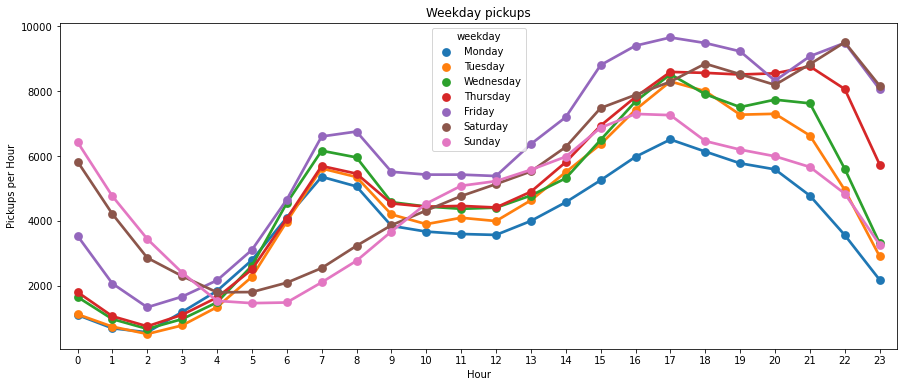

In [9]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

sns.pointplot(ax=ax, x='hour',y='pickups_count',hue='weekday', data = weekday_hourly_pickups)

ax.set_title('Weekday pickups')
ax.set_ylabel('Pickups per Hour')
ax.set_xlabel('Hour')

<pre>
📝 <b>Notes</b>
<div style="background-color:#C2F2ED;"> 
<li>There are some common trends over most of the week days described by a small peak at the morning (between 6 and 8 am) and a large peak near to close of business (around 5 pm) that continues through the evening.

<li>At the morning hours, weekends shows different trends. At the end of the day before, there is an increasing demand for drivers. However, there is no morning rush as the other week days between 6 and 8 am.

<li>Friday show the largest evening demand. However, Saturday and Sunday early mornings (between midnight and 2 am) demands are more significant.
</div> </pre> 

## Spatial Pickups Analysis

<pre>
📝 <b>Notes</b>
<div style="background-color:#C2F2ED;"> 
<li>At this level, we want to show how pickups locations are spatially distributed over New York city to get some first insights about what ML technique we can use.
<li>In the weekday_hourly plot above, we have noticed that are 3 peaks at 8am, 5pm and 10pm on Friday. Are they located in the same zone? 
</div> </pre> 

In [10]:
def pickups_day_hour(pickups, day, hour):
    pickups_dh = pickups.loc[(pickups['weekday'] == day) & (pickups['hour'] == hour)]
    return pickups_dh

def generate_fig(data, title):
    fig= px.scatter_mapbox(
        data, 
        lat="Lat", 
        lon="Lon",
        mapbox_style="carto-positron",
        zoom = 10,
        title='Hour: ' + str(title),
        width=1500, height=600
    )
    return fig

<pre>
📝 <b>Notes</b>
<div style="background-color:#C2F2ED;"> 
Unfortunately, we cannot use subplots with maps given the current plot libraries !! Hence, we will show maps subsequently.
</div> </pre> 

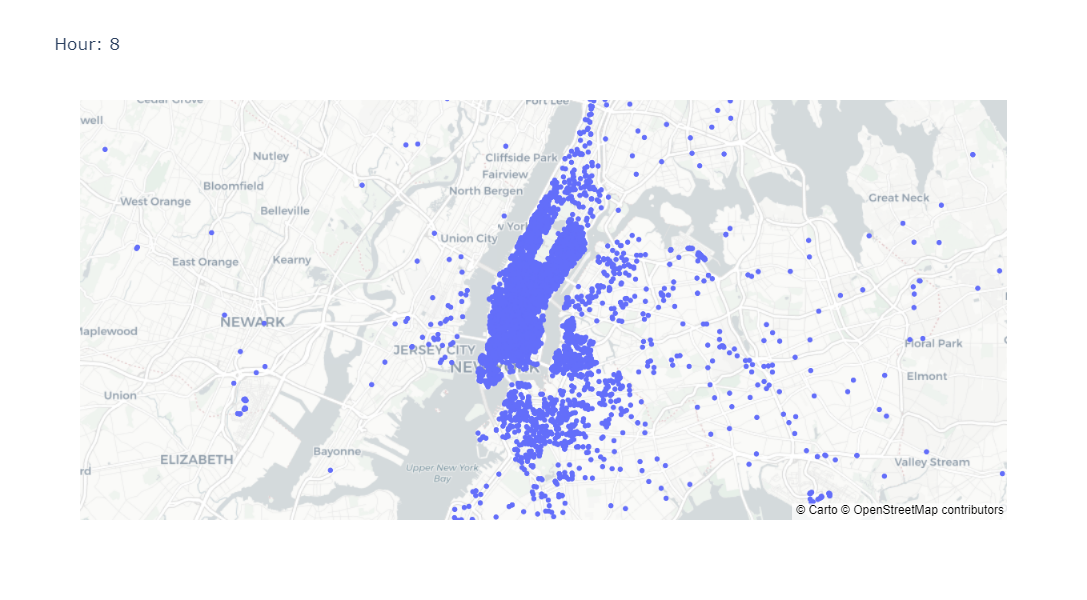

In [14]:
day = 4
hours = [8, 17, 22]

pickups_dh = pickups_day_hour(pickups, day, hours[0])
fig = generate_fig(pickups_dh, hours[0])
fig.show()

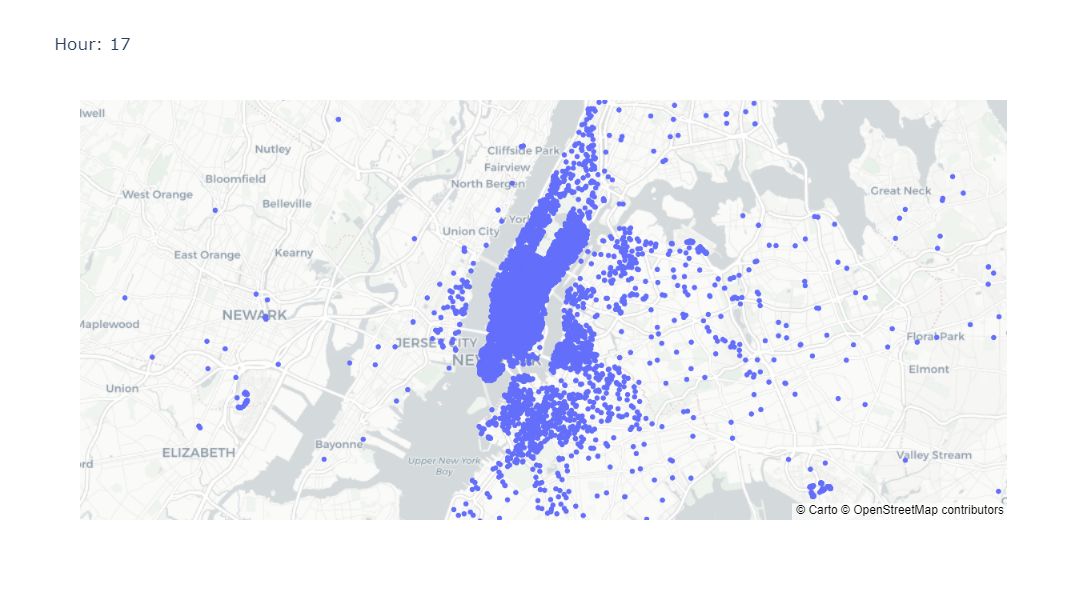

In [12]:
pickups_dh = pickups_day_hour(pickups, day, hours[1])
fig = generate_fig(pickups_dh, hours[1])
fig.show()

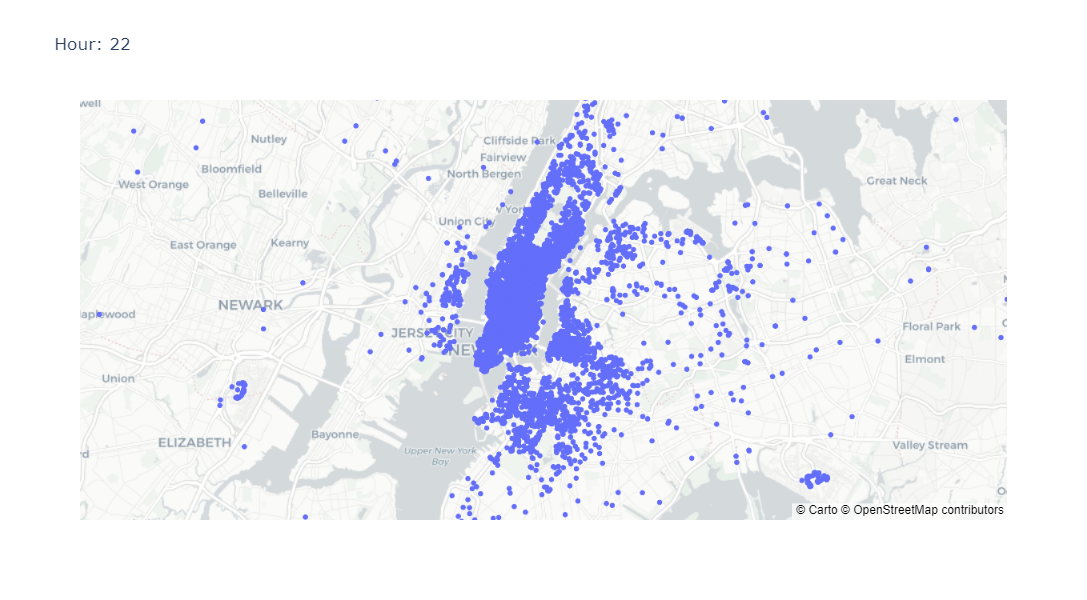

In [13]:
pickups_dh = pickups_day_hour(pickups, day, hours[2])
fig = generate_fig(pickups_dh, hours[2])
fig.show()

<pre>
📝 <b>Notes</b>
<div style="background-color:#C2F2ED;"> 
At all of the peak hours, the most condensed traffic is in <b>Manhattan</b> with some other small hot spots on the <b>Brooklyn</b> side of the East River. This is totally expected because <b>Manhattan</b> is the most densely populated of New York City’s 5 boroughs where the major commercial, financial and cultural centers are located.
</div> </pre> 

# Key Insights

> Recall that the goal is to recommend hot spots at any given time of the day. Given the data structure, we can conclude that this goal can be achieved using **Clustering** techniques.
>> There are 2 Clustering methods that can be applied to the current problem: **Centroid-based Clustering** such as **K-Means** and **Density-based Clustering** such as **DBSCAN**. The **pickups spatial distribution** and the **goal definition** are the key indicators to decide between these 2 methods. 

>> First, looking at the pickups spatial distribution, we can conclude that the clusters cannot be **convex**. Second, there are lot of **outliers** (locations with very few traffic).
>>> **K-means** fails with non-convex clusters and cannot properly handle outliers. In addition, it requires the clusters number as prior information which is not practical for drivers to set such parameter. 

>>> On the other hand, **DBSCAN** is a density-based method that suits better the goal definition as we want to find the hot-zones (the dense zones). In addition, it can separate non-convex clusters and properly handle outliers. Finally, it does not require the clusters number to be defined prior to clustering but requires other 2 parameters that are the Radius and the minimum points for clustering. However, these 2 parameters if restated in simpler words, are very practical for drivers to customize their queries !! 

> Given these conclusions, for this project, we decided to use **DBSCAN** as the clustering method to find the hot-spots for UBER drivers in New York city.